In [2]:
import os
import re
import json
results = {}
with open('./results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)
    
codigos = results.keys()

In [3]:

# result = { 
#     "pontuacao" : None,
#     "n_subtarefas" : None,
#     "subtarefas100" : None,
#     "tempo_lim" : None,
#     "mem_lim" : None,
#     "tempo" : None,
#     "mem" : None,
#     "comp" : None,
#     "stderr" : None 
# }
list_error = []
list_warning = []
list_accepted = []
list_TLE = []
list_MLE = []
for codigo in codigos:
    data = results[codigo]
    if not data["comp"]:
        list_error.append(codigo)
        continue
    if len(data["stderr"])>1:
        list_warning.append(codigo)
    if data["pontuacao"] == 100:
        list_accepted.append(codigo)
    if data["tempo"] >= data["tempo_lim"]:
        list_TLE.append(codigo)
    if data["mem"] >= data["mem_lim"]:
        list_MLE.append(codigo)



    
        

In [4]:

# para encontrar enunciado, considerar 'entrada' após primeira ocorrência de 'Exemplo'
for codigo in codigos:
    with open(f'./pratique/{codigo}/{codigo}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    search = re.search(r'Exemplo', text)
    if search is None:
        print(f'{codigo} sem exemplos.')
        continue
    splitted = text.split('Exemplo')
    if re.search(r'[Ee]ntrada', splitted[0]) is None or re.search(r'[Ss]a[ií]da', splitted[0]) is None:
        print(f'{codigo} com exemplo traiçoeiro.')

In [5]:
def count_words(text):
    return len(re.findall(r'\S+', text))
def get_info(info, codigo):
    info[codigo] = {
        "len_enunciado": None,
        "len_entrada": None,
        "len_saida": None,
        "n_restricoes": None,
        "n_exemplos": None
    }
    text = ''
    with open(f'./pratique/{codigo}/{codigo}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    data = info[codigo]
    enunciado, text = re.split(r'Exemplo',text,maxsplit=1) 
    sections = re.split(r'[Ee]ntrada',text)
    data["len_enunciado"] = count_words(enunciado)
    n_exemplos = len(sections)-1
    len_entrada = 0
    len_saida = 0
    if n_exemplos > 0:
        for section in sections[1:]:
            splitted = re.split(r'\n[^\n]*[Ss]a[ií]da[^\n]*\n',section) # verificado se existe string 'Saida' nos textos # verificado se as strings procuradas existem nos textos
            entrada = splitted[0]
            try:
                saida = splitted[1]
            except:
                print(f'{codigo} com erro.')
                print(section, "AAAA", splitted)
                return
            if len(entrada.strip()) == 0 or len(saida.strip()) == 0:
                print(f'{codigo} com entrada ou saida vazia.')
                return
            len_entrada += count_words(entrada)
            len_saida += count_words(saida)
        len_entrada /= n_exemplos
        len_saida /= n_exemplos
        data["len_entrada"] = len_entrada
        data["len_saida"] = len_saida
    data["n_exemplos"] = n_exemplos
    data["n_restricoes"] = enunciado.count('≤')+enunciado.count('≥')
info = {}
ignore = ['2011_p1_f1_pulosapo'] # foge do modelo de enunciado
for codigo in codigos:
    if codigo in ignore:
        continue
    get_info(info, codigo)

info['2011_p1_f1_pulosapo'] = {
    "len_enunciado": 357,
    "len_entrada": 8.0,
    "len_saida": 12.5,
    "n_restricoes": 4,
    "n_exemplos": 2
}
        

In [6]:
comentarios = {}
def get_comentarios(comentarios, codigo):
    with open(f'./pratique/{codigo}/{codigo}.cpp', 'r', encoding='utf-8') as f:
        code = f.read()
    search = re.findall(r'(//.*?$|/\*.*?\*/)', code, re.DOTALL | re.MULTILINE)
    if len(search) > 0:
        comentarios[codigo] = search
for codigo in codigos:
    get_comentarios(comentarios, codigo)


In [7]:
contain_image = []
with open('./pratique/contain_image.json', 'r', encoding='utf-8') as f:
    contain_image = json.load(f)
for i in range(len(contain_image)):
    splitted = contain_image[i].split('/')
    nivel = splitted[2]
    edicao = splitted[3]
    fase = splitted[4]
    nome = splitted[5]
    contain_image[i] = f'{edicao}_{nivel}_{fase}_{nome}'

In [8]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Configurações globais para os gráficos
# sns.set_theme(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams["font.size"] = 12

# Convertendo os dicionários em DataFrames para facilitar a análise
results_df = pd.DataFrame.from_dict(results, orient="index")
info_df = pd.DataFrame.from_dict(info, orient="index")

# Unindo os dois DataFrames
df = results_df.join(info_df)
df["edicao"] = df.index.str.split("_").str[0]
df["nivel"] = df.index.str.split("_").str[1]
df["fase"] = df.index.str.split("_").str[2]
df["contain_image"] = df.index.isin(contain_image)
df.loc[(df["comp"]==False), "pontuacao"] = 0
# Valid df: compilation success, not TLE, not MLE
# Use .loc[] to create the new column
bins = [0, 200, 400, np.inf]
labels = ["<=200", "<=400", ">400"]
df.loc[:, 'len_enunciado_group'] = pd.cut(
    df['len_enunciado'],
    bins=bins,
    labels=labels,
    right=True
)
df_comp = df[(df["comp"] == True)]



bins = [0, 5, 10, np.inf]
labels = ["1-5", "6-10", "11+"]


# Use .loc[] to create the new column
df_comp.loc[:, 'n_subtarefas_group'] = pd.cut(
    df_comp['n_subtarefas'],
    bins=bins,
    labels=labels,
    right=True
)





df_noerror = df_comp[(~df_comp.index.isin(list_TLE)) & (~df_comp.index.isin(list_MLE))]
df_TLE = df_comp[(df_comp.index.isin(list_TLE))]
df_MLE = df_comp[(df_comp.index.isin(list_MLE))]
df_image = df[df["contain_image"] == True]
df_noimage = df[df["contain_image"] == False]



C:\Users\analc\AppData\Local\Temp\ipykernel_9960\2331089596.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp.loc[:, 'n_subtarefas_group'] = pd.cut(


In [8]:
print(df['fase'].value_counts()) 
print(df['nivel'].value_counts())
print(df['contain_image'].value_counts())
print(df['len_enunciado_group'].value_counts())
print(df_comp['n_subtarefas_group'].value_counts())

fase
f2    198
f1    190
f3     72
Name: count, dtype: int64
nivel
p2    161
p1    128
pj    106
ps     65
Name: count, dtype: int64
contain_image
False    298
True     162
Name: count, dtype: int64
len_enunciado_group
<=400    316
>400      90
<=200     54
Name: count, dtype: int64
n_subtarefas_group
6-10    197
1-5     161
11+      52
Name: count, dtype: int64


In [12]:
print(df['len_enunciado'].min(), df['len_enunciado'].max())
print(df_comp['n_subtarefas'].min(), df_comp['n_subtarefas'].max())
print(df['n_exemplos'].min(), df['n_exemplos'].max())
print((df["pontuacao"]==100).sum())

122 745
2.0 20.0
1 6
140


In [55]:
enunciados = [info[codigo]['len_enunciado'] for codigo in codigos]
print(max(enunciados))
print(min(enunciados))
entradas = [info[codigo]['len_entrada'] for codigo in codigos]
print(max(entradas))
print(min(entradas))
saidas = [info[codigo]['len_saida'] for codigo in codigos]
print(max(saidas))
print(min(saidas))
exemplos = [info[codigo]['n_exemplos'] for codigo in codigos]
print(max(exemplos))
print(min(exemplos))

745
122
225.0
1.0
45.333333333333336
1.0
6
1


C:\Users\analc\AppData\Local\Temp\ipykernel_9696\3236327373.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=15)


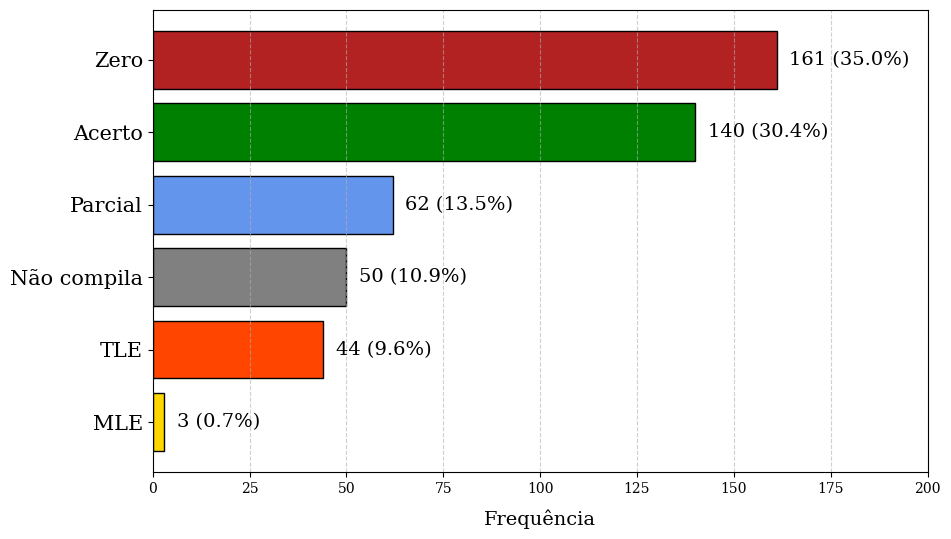

In [29]:
plt.rcParams["font.family"] = "serif"  
comp_false = (df["comp"]==False).sum()
tle = (df.index.isin(list_TLE)).sum()
mle = (df.index.isin(list_MLE)).sum()
score0 = ((df["comp"]==True) & (~df.index.isin(list_TLE)) & (~df.index.isin(list_MLE)) & (df["pontuacao"]==0)).sum()
score100 = (df["pontuacao"]==100).sum()
other = len(df) - score100 - score0 - comp_false - tle - mle

# Dados
labels = ["Não compila", "MLE", "TLE", "Zero", "Acerto", "Parcial"]
sizes = [comp_false, mle, tle, score0, score100, other]
colors = ['gray', 'gold', 'orangered', 'firebrick', 'green', 'cornflowerblue']

# Ordenando do maior para o menor (opcional)
sorted_indices = np.argsort(sizes)[::-1]
labels = [labels[i] for i in sorted_indices]
sizes = [sizes[i] for i in sorted_indices]
colors = [colors[i] for i in sorted_indices]

# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(labels, sizes, color=colors, edgecolor='black')

# Adicionando os valores nas barras
for bar, size in zip(bars, sizes):
    ax.text(bar.get_width() + max(sizes) * 0.02, bar.get_y() + bar.get_height()/2,
            f"{size} ({size/sum(sizes)*100:.1f}%)", va='center', fontsize=14)

ax.set_xlabel("Frequência", fontsize=14, labelpad=10)
ax.set_yticklabels(labels, fontsize=15)
ax.set_xlim(0, 200)
plt.gca().invert_yaxis()  # Inverte a ordem para manter do maior para o menor
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


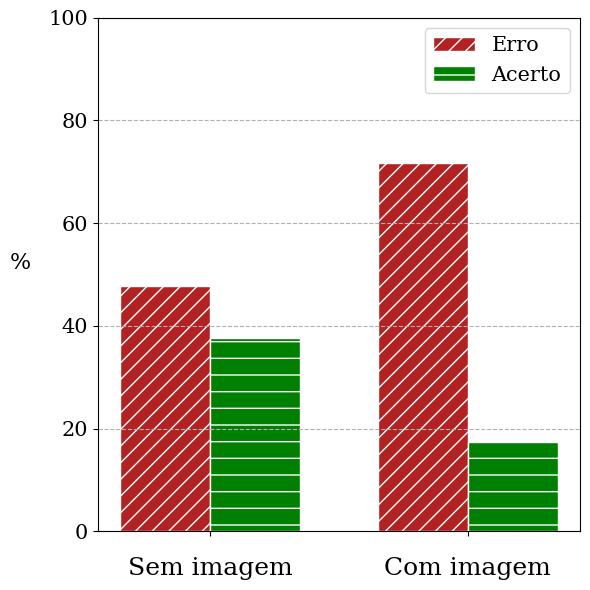

In [39]:

data1 = [
    ((df_noimage["comp"] == False) | 
     (df_noimage.index.isin(list_TLE)) | 
     (df_noimage.index.isin(list_MLE)) | 
     (df_noimage["pontuacao"] == 0)).sum() / len(df_noimage) * 100,

    ((df_image["comp"] == False) | 
     (df_image.index.isin(list_TLE)) | 
     (df_image.index.isin(list_MLE)) | 
     (df_image["pontuacao"] == 0)).sum() / len(df_image) * 100
]

data2 = [
    (df_noimage["pontuacao"] == 100).sum() / len(df_noimage) * 100,
    (df_image["pontuacao"] == 100).sum() / len(df_image) * 100
]

# Define labels and positions
labels = ["Sem imagem", "Com imagem"]
x = np.arange(len(labels))

# Define bar width and patterns for grayscale visibility
width = 0.35  # Width of bars

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot bars with colors and patterns
bars1 = ax.bar(x - width/2, data1, width, label='Erro', color='firebrick', hatch='//', edgecolor='white')
bars2 = ax.bar(x + width/2, data2, width, label='Acerto', color='green', hatch='-', edgecolor='white')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--')
ax.xaxis.grid(False)
# Set y-axis ticks to go in increments of 10
ax.set_yticks(np.arange(0, 101, 20))
# Labels and title
ax.set_ylabel("%", fontdict={'fontsize': 16}, rotation=0, labelpad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontdict={'fontsize': 18})
ax.tick_params(axis='x', which='major', pad=15)

ax.legend(prop={'size': 15})

# Make y ticks bolder and bigger
for label in ax.get_yticklabels():
    label.set_fontsize(15)
    

# Display plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


# incluir pontuacao media por categoria


In [26]:
def get_stats(df):
    comp_false = (df["comp"]==False).sum()
    tle = (df.index.isin(list_TLE)).sum()
    mle = (df.index.isin(list_MLE)).sum()
    score0 = ((df["comp"]==True) & (~df.index.isin(list_TLE)) & (~df.index.isin(list_MLE)) & (df["pontuacao"]==0)).sum()
    score100 = (df["pontuacao"]==100).sum()
    other = len(df) - score100 - score0 - comp_false - tle - mle
    print('comp_false', comp_false, comp_false/len(df)*100,'%','mle', mle,mle/len(df)*100,'%','tle', tle,tle/len(df)*100,'%',  'score0', score0,score0/len(df)*100,'%', 'score100', score100, score100/len(df)*100,'%','other', other, other/len(df)*100,'%')
    
print('Sem imagem')
get_stats(df_noimage)
print('Com imagem')
get_stats(df_image)

Sem imagem
comp_false 30 10.06711409395973 % mle 3 1.006711409395973 % tle 21 7.046979865771812 % score0 88 29.53020134228188 % score100 112 37.58389261744966 % other 44 14.76510067114094 %
Com imagem
comp_false 20 12.345679012345679 % mle 0 0.0 % tle 23 14.19753086419753 % score0 73 45.06172839506173 % score100 28 17.28395061728395 % other 18 11.11111111111111 %


In [29]:
print(df_comp['n_subtarefas'].min(), df_comp['n_subtarefas'].max())
print(df_comp['n_subtarefas_group'].value_counts())
print('Pontuação média + Porcentagem de acerto:')
media_subtarefas = [(group, df_comp[df_comp['n_subtarefas_group'] == group]['pontuacao'].mean(), (df_comp[df_comp['n_subtarefas_group'] == group]['pontuacao']==100).sum()/(df_comp['n_subtarefas_group'] == group).sum()*100) for group in ["1-5", "6-10", "11+"]]
print(media_subtarefas)
print('Média geral de pontuação (compilados):', df_comp['pontuacao'].mean())
print('Acertos gerais:', (df_comp['pontuacao']==100).sum()/len(df_comp)*100)
print('Quantidade de acertos:')
for group in ["1-5", "6-10", "11+"]:
    print(group, (df_comp[df_comp['n_subtarefas_group'] == group]['pontuacao']==100).sum())
    

2.0 20.0
n_subtarefas_group
6-10    197
1-5     161
11+      52
Name: count, dtype: int64
Pontuação média + Porcentagem de acerto:
[('1-5', np.float64(41.67701863354037), np.float64(38.50931677018634)), ('6-10', np.float64(40.253807106598984), np.float64(30.96446700507614)), ('11+', np.float64(48.65384615384615), np.float64(32.69230769230769))]
Média geral de pontuação (compilados): 41.8780487804878
Acertos gerais: 34.146341463414636
Quantidade de acertos:
1-5 62
6-10 61
11+ 17


In [24]:
print(df['fase'].value_counts())
print(df['nivel'].value_counts())
fases = ['f1', 'f2', 'f3']
niveis = ['pj', 'p1', 'p2', 'ps']
media_fases = [(fase, df[df['fase'] == fase]['len_enunciado'].mean(), df[df['fase'] == fase]['n_exemplos'].mean()) for fase in fases]
media_niveis = [(nivel, df[df['nivel'] == nivel]['len_enunciado'].mean(), df[df['nivel'] == nivel]['n_exemplos'].mean()) for nivel in niveis]
print('Média de tam. de enunciado + Média de exemplos:')
print(media_fases)
print(media_niveis)
print('Média geral de tam. de enunciado:', df['len_enunciado'].mean())
print('Média geral de exemplos:',df['n_exemplos'].mean())

fase
f2    198
f1    190
f3     72
Name: count, dtype: int64
nivel
p2    161
p1    128
pj    106
ps     65
Name: count, dtype: int64
Média de tam. de enunciado + Média de exemplos:
[('f1', np.float64(304.87894736842105), np.float64(2.6052631578947367)), ('f2', np.float64(334.35858585858585), np.float64(2.691919191919192)), ('f3', np.float64(323.375), np.float64(2.6805555555555554))]
[('pj', np.float64(283.7641509433962), np.float64(2.7169811320754715)), ('p1', np.float64(315.359375), np.float64(2.65625)), ('p2', np.float64(346.3167701863354), np.float64(2.627329192546584)), ('ps', np.float64(326.32307692307694), np.float64(2.6153846153846154))]
Média geral de tam. de enunciado: 320.4630434782609
Média geral de exemplos: 2.6543478260869566


In [30]:
print(df['len_enunciado'].min(), df['len_enunciado'].max())
print(df['len_enunciado_group'].value_counts())
print('Pontuação média + Porcentagem de acerto:')
media_enunciado = [(group, df[df['len_enunciado_group'] == group]['pontuacao'].mean(), (df[df['len_enunciado_group'] == group]['pontuacao']==100).sum()/(df['len_enunciado_group'] == group).sum()*100) for group in ["<=200", "<=400", ">400"]]
print(media_enunciado)
print('Média geral de pontuação:', df['pontuacao'].mean())
print('Acertos gerais:', (df['pontuacao']==100).sum()/len(df)*100)
for group in ["<=200", "<=400", ">400"]:
    print(group, (df[df['len_enunciado_group'] == group]['pontuacao']==100).sum())

122 745
len_enunciado_group
<=400    316
>400      90
<=200     54
Name: count, dtype: int64
Pontuação média + Porcentagem de acerto:
[('<=200', np.float64(50.55555555555556), np.float64(44.44444444444444)), ('<=400', np.float64(39.572784810126585), np.float64(32.91139240506329)), ('>400', np.float64(21.5), np.float64(13.333333333333334))]
Média geral de pontuação: 37.32608695652174
Acertos gerais: 30.434782608695656
<=200 24
<=400 104
>400 12


In [ ]:
print(df['n_exemplos'].min(), df['n_exemplos'].max())
print(df['n_exemplos'].value_counts())
print('Pontuação média + Porcentagem de acerto:')
media_exemplos = [(group, df[df['n_exemplos'] == group]['pontuacao'].mean(), (df[df['n_exemplos'] == group]['pontuacao']==100).sum()/(df['n_exemplos'] == group).sum()*100) for group in range(1, 7)]
print(media_exemplos)
print('Média geral de pontuação:', df['pontuacao'].mean())
print('Acertos gerais:', (df['pontuacao']==100).sum()/len(df)*100)
for group in range(1, 7):
    print(group, (df[df['n_exemplos'] == group]['pontuacao']==100).sum())

1 6
n_exemplos
3    218
2    198
4     27
5      9
1      6
6      2
Name: count, dtype: int64
[(1, np.float64(33.333333333333336), np.float64(33.33333333333333)), (2, np.float64(37.398989898989896), np.float64(32.82828282828283)), (3, np.float64(38.50917431192661), np.float64(28.899082568807337)), (4, np.float64(38.888888888888886), np.float64(33.33333333333333)), (5, np.float64(11.11111111111111), np.float64(11.11111111111111)), (6, np.float64(10.0), np.float64(0.0))]
Média geral: 37.32608695652174
Acertos gerais: 30.434782608695656


In [ ]:
print(df['fase'].value_counts())
print(df['nivel'].value_counts())
fases = ['f1', 'f2', 'f3']
niveis = ['pj', 'p1', 'p2', 'ps']
print('Pontuação média + Porcentagem de acerto:')
media_fases = [(fase, df[df['fase'] == fase]['pontuacao'].mean(), (df[df['fase'] == fase]['pontuacao']==100).sum()/(df['fase'] == fase).sum()*100) for fase in fases]
media_niveis = [(nivel, df[df['nivel'] == nivel]['pontuacao'].mean(), (df[df['nivel'] == nivel]['pontuacao']==100).sum()/(df['nivel'] == nivel).sum()*100) for nivel in niveis]
print(media_fases)
print(media_niveis)
print('Média geral de pontuação:', df['pontuacao'].mean())
print('Acertos gerais:', (df['pontuacao']==100).sum()/len(df)*100)
for fase in fases:
    print(fase, (df[df['fase'] == fase]['pontuacao']==100).sum())
for nivel in niveis:
    print(nivel, (df[df['nivel'] == nivel]['pontuacao']==100).sum())
# efeito da baixa amostra de exercicios de nivel universitario

fase
f2    198
f1    190
f3     72
Name: count, dtype: int64
nivel
p2    161
p1    128
pj    106
ps     65
Name: count, dtype: int64
[('f1', np.float64(43.3421052631579), np.float64(36.31578947368421)), ('f2', np.float64(34.898989898989896), np.float64(28.28282828282828)), ('f3', np.float64(28.125), np.float64(20.833333333333336))]
[('pj', np.float64(66.22641509433963), np.float64(58.490566037735846)), ('p1', np.float64(34.375), np.float64(28.125)), ('p2', np.float64(24.099378881987576), np.float64(15.527950310559005)), ('ps', np.float64(28.76923076923077), np.float64(26.153846153846157))]
37.32608695652174
30.434782608695656


In [ ]:
print(df_comp['fase'].value_counts())
print(df_comp['nivel'].value_counts())
fases = ['f1', 'f2', 'f3']
niveis = ['pj', 'p1', 'p2', 'ps']
print('Porcentagem de TLE (compilados):')
media_fases = [(fase, (df_comp[df_comp['fase']==fase].index.isin(list_TLE)).sum()/(df_comp['fase'] == fase).sum()*100) for fase in fases]
media_niveis = [(nivel, (df_comp[df_comp['nivel']==nivel].index.isin(list_TLE)).sum()/(df_comp['nivel'] == nivel).sum()*100) for nivel in niveis]
print(media_fases)
print(media_niveis)
print('Porcentagem geral de TLE (compilados):', (df_comp.index.isin(list_TLE)).sum()/len(df_comp)*100)
for fase in fases:
    print(fase, (df[df['fase'] == fase]['pontuacao']==100).sum())
for nivel in niveis:
    print(nivel, (df[df['nivel'] == nivel]['pontuacao']==100).sum())

fase
f1    172
f2    172
f3     66
Name: count, dtype: int64
nivel
p2    139
p1    113
pj    102
ps     56
Name: count, dtype: int64
[('f1', np.float64(9.883720930232558)), ('f2', np.float64(11.627906976744185)), ('f3', np.float64(10.606060606060606))]
[('pj', np.float64(4.901960784313726)), ('p1', np.float64(8.849557522123893)), ('p2', np.float64(17.26618705035971)), ('ps', np.float64(8.928571428571429))]
10.731707317073171


In [ ]:
print(df['fase'].value_counts())
print(df['nivel'].value_counts())
fases = ['f1', 'f2', 'f3']
niveis = ['pj', 'p1', 'p2', 'ps']
print('Porcentagem de erro de compilação:')
media_fases = [(fase, ((df['comp']==False) & (df['fase']==fase)).sum()/(df['fase'] == fase).sum()*100) for fase in fases]
media_niveis = [(nivel, ((df['comp']==False) & (df['nivel']==nivel)).sum()/(df['nivel'] == nivel).sum()*100) for nivel in niveis]
print(media_fases)
print(media_niveis)
print('Porcentagem geral de erro de compilação:', (df['comp']==False).sum()/len(df)*100)
for fase in fases:
    print(fase, ((df['comp']==False) & (df['fase']==fase)).sum())
for nivel in niveis:
    print(nivel, ((df['comp']==False) & (df['nivel']==nivel)).sum())

fase
f2    198
f1    190
f3     72
Name: count, dtype: int64
nivel
p2    161
p1    128
pj    106
ps     65
Name: count, dtype: int64
[('f1', np.float64(9.473684210526317)), ('f2', np.float64(13.131313131313133)), ('f3', np.float64(8.333333333333332))]
[('pj', np.float64(3.7735849056603774)), ('p1', np.float64(11.71875)), ('p2', np.float64(13.664596273291925)), ('ps', np.float64(13.846153846153847))]
10.869565217391305


In [34]:
print('Porcentagem de TLE (compilados):')
media_enunciado = [(group, (df_comp[df_comp['len_enunciado_group'] == group].index.isin(list_TLE)).sum(), (df_comp[df_comp['len_enunciado_group'] == group].index.isin(list_TLE)).sum()/(df_comp['len_enunciado_group'] == group).sum()*100) for group in ["<=200", "<=400", ">400"]]
print(media_enunciado)

print('Porcentagem geral de TLE (compilados):', (df_comp.index.isin(list_TLE)).sum()/len(df_comp)*100)

Porcentagem de TLE (compilados):
[('<=200', np.int64(1), np.float64(2.0)), ('<=400', np.int64(24), np.float64(8.421052631578947)), ('>400', np.int64(19), np.float64(25.333333333333336))]
Porcentagem geral de TLE (compilados): 10.731707317073171


In [20]:
print('Porcentagem de TLE (compilados):')
media_exemplos = [(group, (df_comp[df_comp['n_exemplos'] == group].index.isin(list_TLE)).sum()/(df_comp['n_exemplos'] == group).sum()*100) for group in range(1, 7)]
print(media_exemplos)

print('Porcentagem geral de TLE (compilados):', (df_comp.index.isin(list_TLE)).sum()/len(df_comp)*100)

[(1, np.float64(20.0)), (2, np.float64(12.716763005780345)), (3, np.float64(9.230769230769232)), (4, np.float64(3.8461538461538463)), (5, np.float64(22.22222222222222)), (6, np.float64(0.0))]
Porcentagem geral de TLE (entre as que compilaram): 10.731707317073171


In [33]:
print('Erros + Porcentagem de erro de compilação:')
media_enunciado = [(group, ((df['comp']==False) & (df['len_enunciado_group'] == group)).sum(), ((df['comp']==False) & (df['len_enunciado_group'] == group)).sum()/(df['len_enunciado_group'] == group).sum()*100) for group in ["<=200", "<=400", ">400"]]
print(media_enunciado)

Erros + Porcentagem de erro de compilação:
[('<=200', np.int64(4), np.float64(7.4074074074074066)), ('<=400', np.int64(31), np.float64(9.81012658227848)), ('>400', np.int64(15), np.float64(16.666666666666664))]


In [ ]:
print('Porcentagem de erro de compilação:')
media_exemplos = [(group, ((df['comp']==False) & (df['n_exemplos'] == group)).sum()/(df['n_exemplos'] == group).sum()*100) for group in range(1, 7)]
print(media_exemplos)

[(1, np.float64(16.666666666666664)), (2, np.float64(12.626262626262626)), (3, np.float64(10.550458715596331)), (4, np.float64(3.7037037037037033)), (5, np.float64(0.0)), (6, np.float64(0.0))]


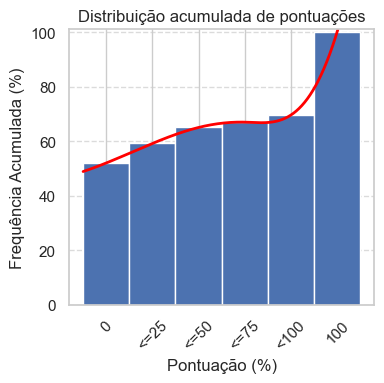

In [122]:
def plot_cdf(pontuacoes):
    bins = [0, 25, 50, 75, 100]
    labels = ['0', '<=25', '<=50', '<=75', '<100', '100']

    counts = [
        (pontuacoes == 0).sum(),
        ((pontuacoes > 0) & (pontuacoes <= 25)).sum(),
        ((pontuacoes > 25) & (pontuacoes <= 50)).sum(),
        ((pontuacoes > 50) & (pontuacoes <= 75)).sum(),
        ((pontuacoes > 75) & (pontuacoes < 100)).sum(),
        (pontuacoes == 100).sum()
    ]

    total_count = len(pontuacoes)
    percentages = [count / total_count * 100 for count in counts]
    cumulative_percentages = np.cumsum(percentages)

    # Create the plot
    plt.figure(figsize=(4, 4))

    # Bar plot (thinner and glued together)
    bar_width = 1 
    bar_positions = np.arange(len(labels)) 

    plt.bar(bar_positions, cumulative_percentages, width=bar_width, align='edge')

    # Ensure the last bin is included properly in the spline interpolation
    x_vals = bar_positions + bar_width / 2  # Adjust x positions
    y_vals = cumulative_percentages

    # Smooth trend curve using spline interpolation
    x_smooth = np.linspace(bar_positions.min(), bar_positions.max() + bar_width, 300)
    spl = make_interp_spline(x_vals, y_vals, k=3)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)

    plt.plot(x_smooth, y_smooth, color='red', linestyle='-', linewidth=2)

    # Set labels and title
    plt.ylim(0, 101)
    plt.xlabel("Pontuação (%)")
    plt.ylabel("Frequência Acumulada (%)")
    plt.title("Distribuição acumulada de pontuações")
    plt.xticks(bar_positions + bar_width / 2, labels, rotation=45)  # Adjust xtick positions
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
pontuacoes = df["pontuacao"]
plot_cdf(pontuacoes)